# Final Project

## Names: MIA TRAN

- Insert Markdown chunks for your written responses as needed
- Do not include unnecessary code. Only code that is needed to answer the questions should be included, nothing more. 
- Be sure your work is **reproducible** by "Restart and Clear Output" then "Run All" cells
- The group leader will make a single submission on Moodle on behalf of the group. 
- **ACKNOWELDGE ALL EXTERNAL SOURCES HERE:** Give a brief summary of any external sources you used. Ex:
    - Google AI overview for XXX
    - StackOverflow for YYY

In [27]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# We will turn of the future warnings that xgboost gives us
import warnings   
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1. The Data

The dataset we chose is [Predict Podcast Listening Time](https://www.kaggle.com/competitions/playground-series-s5e4/overview) where:

* Outcome variable: Continuous numerical variable `Listening_Time_minutes`
* Predictor variables: $p = 8$
* Number of observations:
    * Training set: $n_{train} = 750,000$
    * Test set: $n_{test} = 250,000$
* Score/metric used for the [leaderboard](https://www.kaggle.com/competitions/playground-series-s5e4/leaderboard): Root Mean Squared Error (RSME)

In [4]:
# Load train data
df = pd.read_csv("../data/train.csv")
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


## 2. Exploratory Data Analysis

### 2.1. Basis Overview

In [5]:
# Data overview
df.info()
df.describe(include="all")
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

### 2.2. Target Variable Distribution

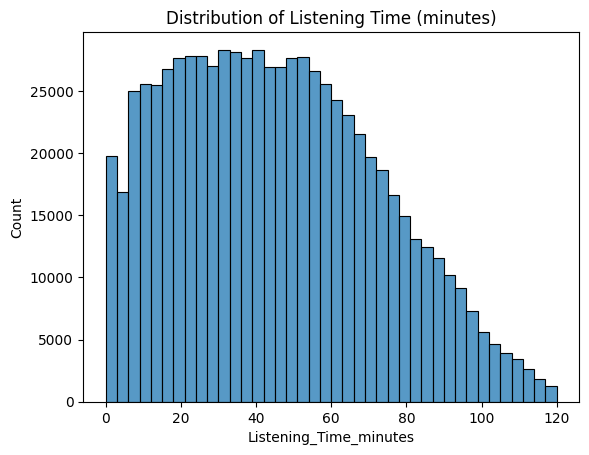

In [7]:
plt.figure()
sns.histplot(df["Listening_Time_minutes"], bins=40)
plt.title("Distribution of Listening Time (minutes)")
plt.xlabel("Listening_Time_minutes")
plt.ylabel("Count")
plt.show()

The target variable is right-skewed, with most listeners staying between 20–60 minutes. Very long listening sessions are rare.

### 2.3. Numeric Feature Distributions

<Figure size 1200x800 with 0 Axes>

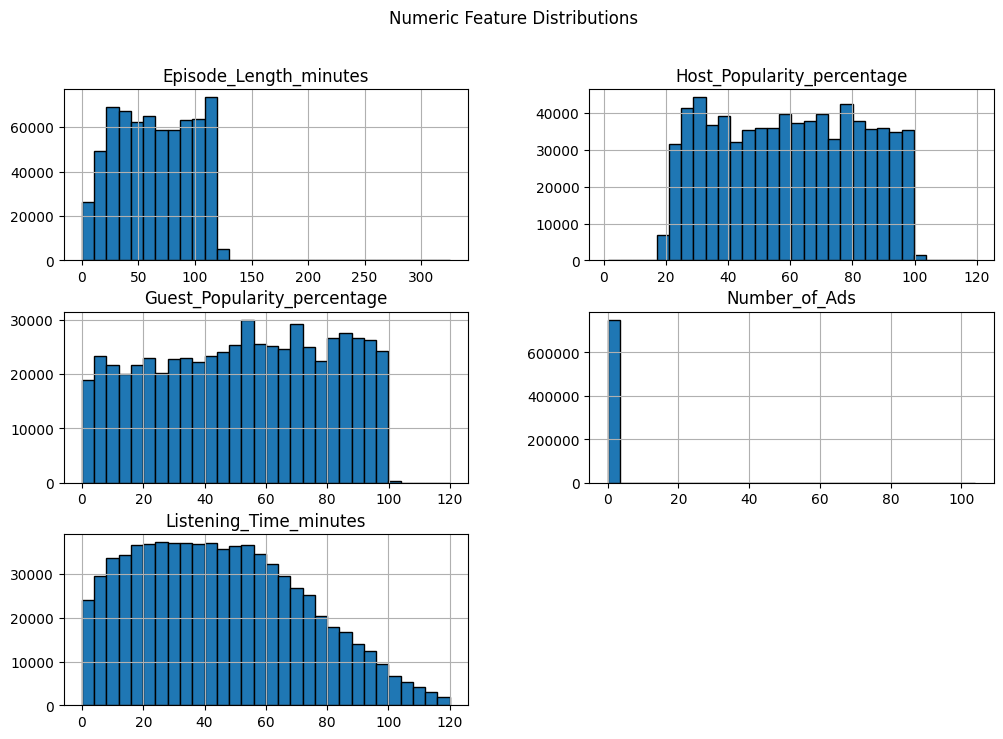

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "id" in num_cols: 
    num_cols.remove("id")

plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=30, figsize=(12, 8), edgecolor="black")
plt.suptitle("Numeric Feature Distributions")
plt.show()

The numeric features show distinct distribution patterns. **Episode_Length_minutes** is roughly bell-shaped with most episodes between about 20–80 minutes, while both **Host_Popularity_percentage** and **Guest_Popularity_percentage** are spread fairly evenly across their ranges, indicating a wide variety of creator and guest prominence. **Number_of_Ads** is extremely right-skewed, with the vast majority of episodes containing very few ads and only a small number containing many ads. Finally, the target **Listening_Time_minutes** is right-skewed, with most listeners staying between roughly 20–60 minutes and very long listening sessions being relatively rare.

### 2.4. Categorical Distributions

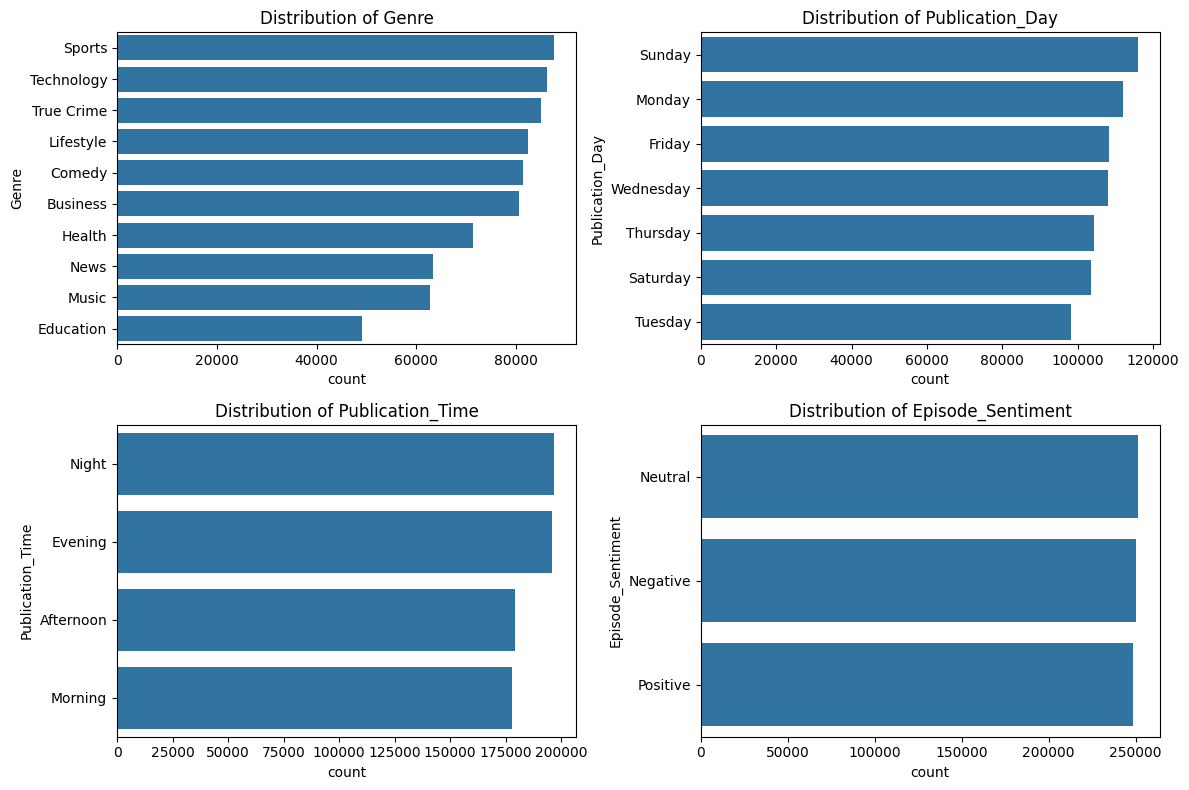

In [11]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in ["Podcast_Name", "Episode_Title"]:
    if col in cat_cols:
        cat_cols.remove(col)

def plot_cats(df, cat_cols):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for i, col in enumerate(cat_cols):
        sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

plot_cats(df, cat_cols)

The categorical features show broad and well-balanced representation across their levels. **Genre** spans a wide range of podcast types, with no single genre overwhelmingly dominant, suggesting diverse content in the dataset. **Publication_Day** is also evenly distributed across the week, indicating that episodes are released consistently rather than clustered on certain days. **Publication_Time** shows clear patterns, with most episodes released in the Evening or Night, potentially aligning with listener behavior. Finally, **Episode_Sentiment** is nearly evenly split among Positive, Neutral, and Negative categories, reflecting a variety of emotional tones in podcast content. Overall, the categorical features exhibit strong variability without extreme imbalance, making them reasonable candidates for encoding in predictive modeling.

### 2.5. Correlations

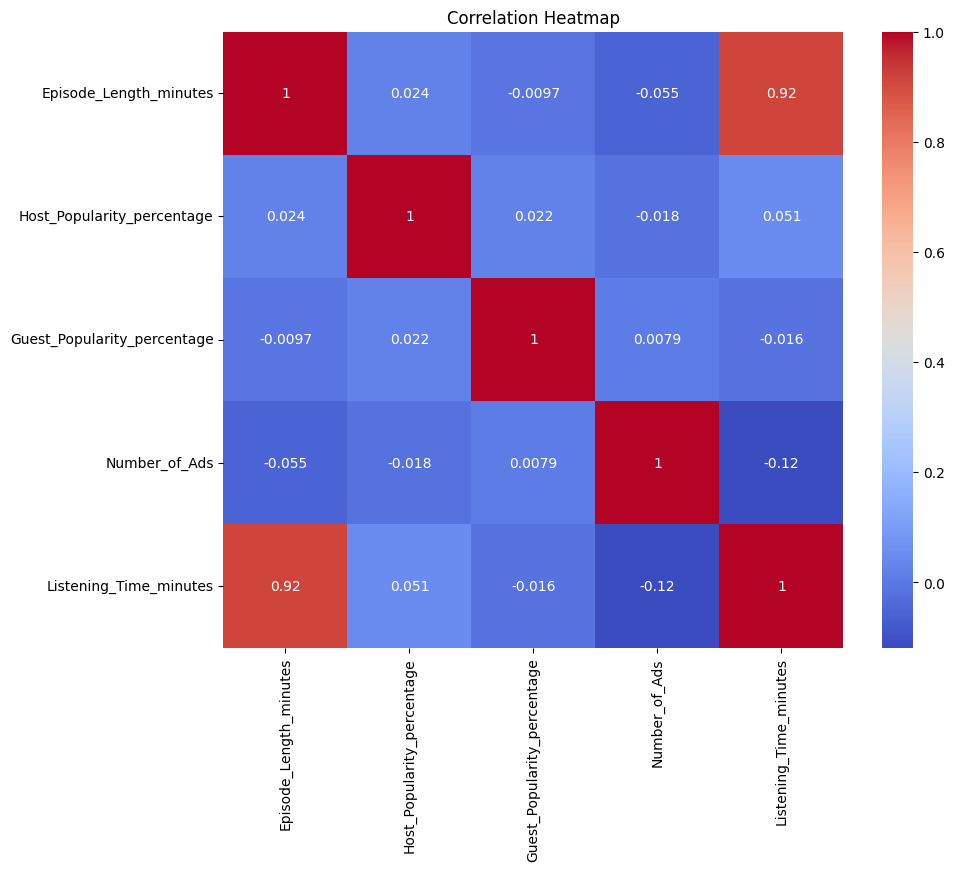

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The correlation matrix shows that most numeric features have very weak relationships with one another and with the target variable. The only strong association is between **Episode_Length_minutes** and **Listening_Time_minutes**, with a correlation of approximately **0.92**, indicating that longer episodes tend to be listened to for longer periods. All other predictors like **Host_Popularity_percentage**, **Guest_Popularity_percentage**, and **Number_of_Ads** exhibit correlations close to zero, suggesting that they provide minimal linear predictive signal on their own. This reinforces that episode length is the dominant driver of listening behavior, while the remaining numeric features may require nonlinear modeling or interaction effects to contribute meaningfully.

## 3. Feature Engineering

In [13]:
# Missing values overview
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct.round(2).to_frame("missing_%")
print(missing_pct)

                             missing_%
Guest_Popularity_percentage      19.47
Episode_Length_minutes           11.61
Number_of_Ads                     0.00
id                                0.00
Podcast_Name                      0.00
Episode_Title                     0.00
Genre                             0.00
Host_Popularity_percentage        0.00
Publication_Day                   0.00
Publication_Time                  0.00
Episode_Sentiment                 0.00
Listening_Time_minutes            0.00


The feature **Guest_Popularity_percentage** has a high missing percentage (~19%), which is expected because many episodes do not feature a guest. These nulls are therefore retained as meaningful “no guest” cases, captured through a new indicator feature (Has_Guest), and the popularity score is imputed as **0** to reflect guest absence. For **Episode_Length_minutes** (~12% missing), the missingness likely results from incomplete metadata rather than a meaningful condition. This feature is imputed using the **median** to preserve its distribution. The remaining features have no meaningful missingness, and the lone missing value in **Number_of_Ads** is also filled with the **median** for consistency.

In [14]:
# Cleaning missing values for modeling
df_clean = df.copy()

# Define target column
target_col = "Listening_Time_minutes"

# Remove target from numeric list
num_cols = [c for c in num_cols if c != target_col]

# Create indicator "Has_Guest" for Guest_Popularity_percentage 
# with 1 = has guest, 0 = no guest
df_clean["Has_Guest"] = df_clean["Guest_Popularity_percentage"].notna().astype(int)

# Impute missing guest popularity with 0
df_clean["Guest_Popularity_percentage"] = df_clean["Guest_Popularity_percentage"].fillna(0)

# Impute Episode length and Ads with median
df_clean["Episode_Length_minutes"] = df_clean["Episode_Length_minutes"].fillna(
    df_clean["Episode_Length_minutes"].median()
)
df_clean["Number_of_Ads"] = df_clean["Number_of_Ads"].fillna(
    df_clean["Number_of_Ads"].median()
)


## 4. Data preparation pipelines and pre-processing

### 4.1. Train-test split

In [16]:
X = df_clean[num_cols + cat_cols]
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((600000, 8), (150000, 8))

### 4.2. Preprocessors

In [17]:
# Linear models: scale numeric + one-hot encode categoricals
preprocessor_linear = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Tree-based models: only one-hot encode categoricals
preprocessor_tree = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

## 5. Model Selection & Hyperparameter Tuning

In [19]:
# Linear Regression Pipeline
pipe_lr = Pipeline([
    ("preprocessor", preprocessor_linear),
    ("model", LinearRegression())
])

parms_lr = {
    "model__fit_intercept": [True, False]
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=parms_lr,
    cv=3,
    scoring="neg_root_mean_squared_error"
)

grid_res_lr = grid_lr.fit(X_train, y_train)

print(grid_res_lr.best_params_)
print(-grid_res_lr.best_score_)


{'model__fit_intercept': True}
13.37628627766621


In [20]:
# Ridge Pipeline
pipe_ridge = Pipeline([
    ("preprocessor", preprocessor_linear),
    ("model", Ridge())
])

parms_ridge = {
    "model__alpha": [0.1, 1, 10]
}

grid_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=parms_ridge,
    cv=3,
    scoring="neg_root_mean_squared_error",
)

grid_res_ridge = grid_ridge.fit(X_train, y_train)

print(grid_res_ridge.best_params_)
print(-grid_res_ridge.best_score_)


{'model__alpha': 10}
13.376283345212812


In [21]:
# Lasso Pipeline
pipe_lasso = Pipeline([
    ("preprocessor", preprocessor_linear),
    ("model", Lasso(max_iter=10000))
])

parms_lasso = {
    "model__alpha": [0.001, 0.01, 0.1]
}

grid_lasso = GridSearchCV(
    estimator=pipe_lasso,
    param_grid=parms_lasso,
    cv=3,
    scoring="neg_root_mean_squared_error"
)

grid_res_lasso = grid_lasso.fit(X_train, y_train)

print(grid_res_lasso.best_params_)
print(-grid_res_lasso.best_score_)


{'model__alpha': 0.001}
13.376277558640831


In [ ]:
# Random Forest Pipeline
pipe_rf = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

parms_rf = {
    "model__n_estimators": [200],
    "model__max_depth": [None, 15],
    "model__min_samples_split": [2, 5]
}

# grid_rf = GridSearchCV(
#     estimator=pipe_rf,
#     param_grid=parms_rf,
#     cv=3,
#     scoring="neg_root_mean_squared_error"
# )

# grid_res_rf = grid_rf.fit(X_train, y_train)

# print(grid_res_rf.best_params_)
# print(-grid_res_rf.best_score_)


{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
12.855689606273863


In [24]:
# XGBoost Pipeline
pipe_xgb = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("model", XGBRegressor())
])

parms_xgb = {
    'model__n_estimators': [100, 300, 500],
    "model__max_depth": [4, 6, 8]
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=parms_xgb,
    cv=3,
    scoring="neg_root_mean_squared_error"
)

grid_res_xgb = grid_xgb.fit(X_train, y_train)

print(grid_res_xgb.best_params_)
print(-grid_res_xgb.best_score_)

{'model__max_depth': 4, 'model__n_estimators': 500}
13.079801003375927


## 6. Creation of Final Pipeline

In [25]:
pipe_best = Pipeline([("model", grid_res_lr.best_estimator_)])

models = {
    "model": [
        grid_res_lr.best_estimator_,
        grid_res_ridge.best_estimator_,
        grid_res_lasso.best_estimator_,
        grid_res_rf.best_estimator_,
        grid_res_xgb.best_estimator_,
    ]
}

grid_best = GridSearchCV(pipe_best, models, scoring="neg_root_mean_squared_error", cv=5)
grid_res_best = grid_best.fit(X_train, y_train)

pipe_final = grid_res_best.best_estimator_
pipe_final

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Esti

In [32]:
# Evaluate best model on test set
best_model = grid_res_best.best_estimator_

y_pred_best = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"RMSE: {test_rmse:.2f}")

RMSE: 12.69


## 7. Submission File Creation

In [33]:
test_df = pd.read_csv("../data/test.csv")

# Apply same cleaning as train
test_df_clean = test_df.copy()
test_df_clean["Has_Guest"] = test_df_clean["Guest_Popularity_percentage"].notna().astype(int)
test_df_clean["Guest_Popularity_percentage"] = test_df_clean["Guest_Popularity_percentage"].fillna(0)

test_df_clean["Episode_Length_minutes"] = test_df_clean["Episode_Length_minutes"].fillna(
    test_df_clean["Episode_Length_minutes"].median()
)
test_df_clean["Number_of_Ads"] = test_df_clean["Number_of_Ads"].fillna(
    test_df_clean["Number_of_Ads"].median()
)

X_test_real = test_df_clean[num_cols + cat_cols]

preds = pipe_final.predict(X_test_real)

In [34]:
final_submission = pd.DataFrame({
    "id": test_df["id"],
    "Listening_Time_minutes": preds
})

final_submission.to_csv("final_submission.csv", index=False)
final_submission.head()

,id,Listening_Time_minutes
0,750000,59.703515
1,750001,24.018285
2,750002,51.153360
3,750003,74.985558
4,750004,43.131939


In [31]:
# cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=300)
# scores = cross_val_score(pipe_final, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv)

# np.mean(-scores)

KeyboardInterrupt: 

# 8. Appendix

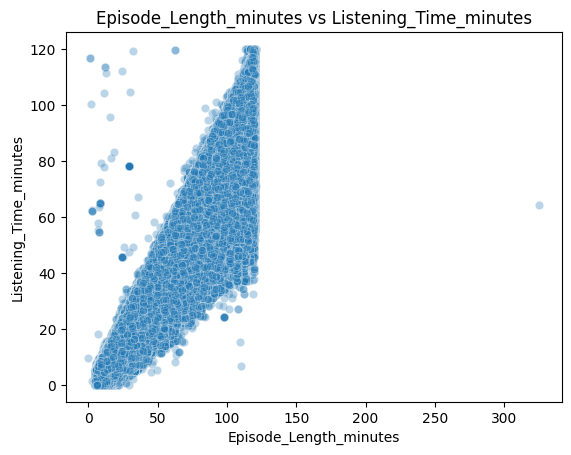

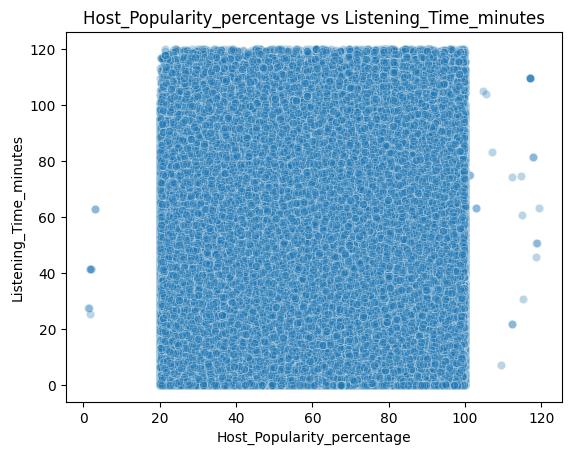

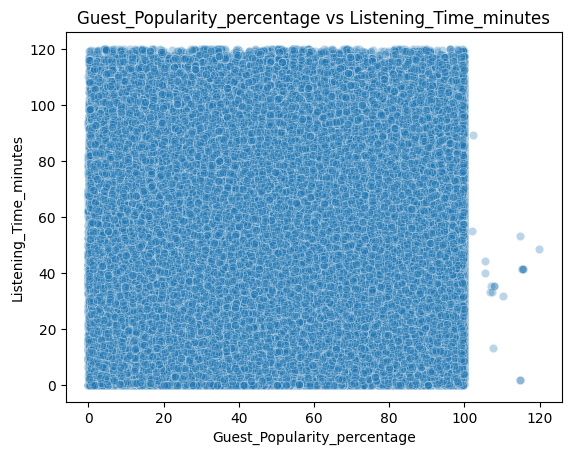

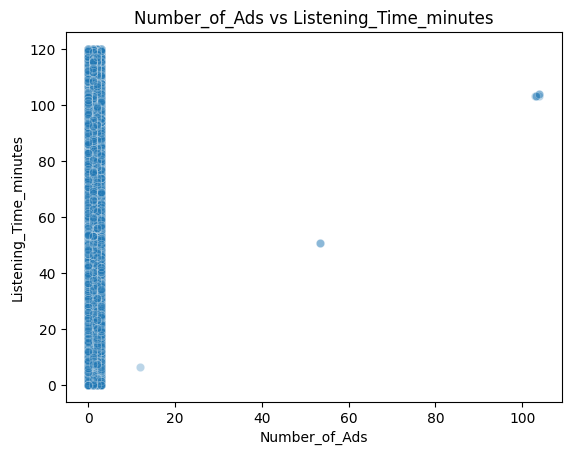

In [35]:
# Scatterplots for numeric features vs Listening_Time_minutes 
for col in num_cols: 
    if col == target_col: 
        continue

    plt.figure()
    sns.scatterplot(data=df, x=col, y=target_col, alpha=0.3)
    plt.title(f"{col} vs {target_col}")
    plt.show()

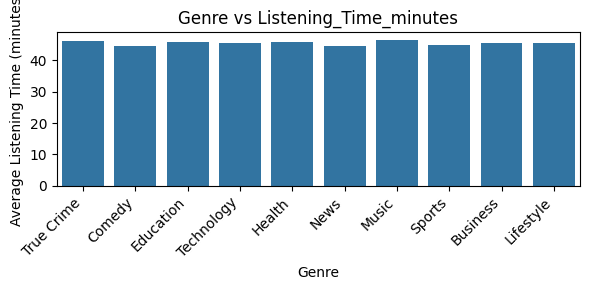

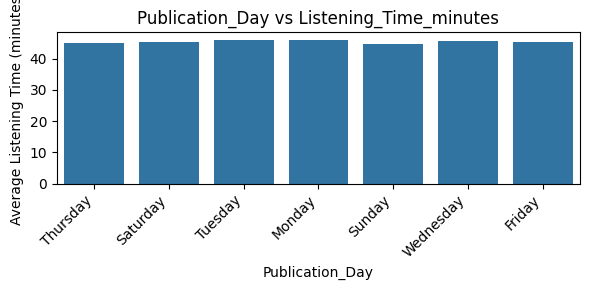

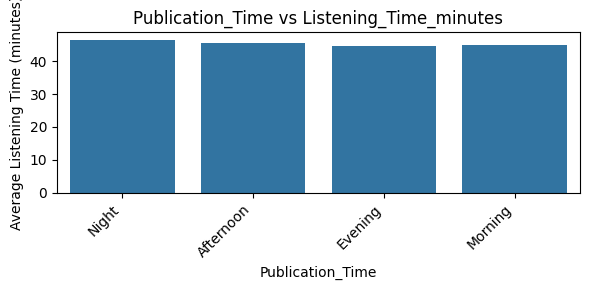

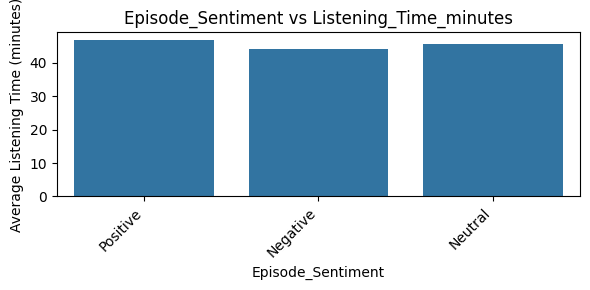

In [36]:
# Bar plots for categorical features vs Listening_Time_minutes
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.barplot(
        x=df[col],
        y=df["Listening_Time_minutes"],
        ci=None
    )
    
    plt.title(f"{col} vs Listening_Time_minutes")
    plt.xlabel(col)
    plt.ylabel("Average Listening Time (minutes)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Across all categorical variables. average listening times are very similar, with only minor differences between categories. This indicates that these categorical attributes have limited direct influence on how long users listen. While certain genres or sentiments show slightly higher averages, the variation is small compared to the dominant effect of episode length. Overall, categorical features appear to provide weak standalone predictive power and may only become useful through interactions or more complex modeling.